<a href="https://colab.research.google.com/github/MaxCojocari/CV_camp_projects/blob/main/cv_heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download --unzip -d ronitf/heart-disease-uci

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 5.72MB/s]


In [ ]:
#Important imports
import torch
from torch import nn as nn # for NN
from torch.utils.data import Dataset # class to create dataset class
from torch import optim # Optimizer
from torch.nn import functional as F # activation functions
import matplotlib.pyplot as plt # to plot a graph
import pandas as pd # py data analysis

DEVICE = torch.device('cudo' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title Default title text
class DataSet(Dataset):
    
    def __init__(self, path):
        self.dataset = torch.tensor(pd.read_csv(path).values)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return self.dataset[i, :-1], self.dataset[i, -1]

In [ ]:
class Net(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.n_features = n_features #13
        
        #fully connected
        self.fc1 = nn.Linear(self.n_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        
        out = F.relu(self.fc1(x)) #activation function (e.g. sigmoid, relu...)
        out = F.relu(self.fc2(out))
        out = F.sigmoid(self.fc3(out))

        return out

In [ ]:
def training_loop(n_epoch, optimizer, model, loss_fn, train_loader, test_loader, print_plot):
    
    train_accuracy = torch.zeros(n_epoch)
    test_accuracy = torch.zeros(n_epoch)
    
    for epoch in range(n_epoch):
        
        for example, label in train_loader:
            
            example = example.to(DEVICE)
            label = label.to(DEVICE)
            
            label = label.unsqueeze(1)
            
            output = model(example.float())
            
            loss = loss_fn(output, label.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        if (epoch+1) % 10 ==0:
            print(f'Epoch {epoch+1})', 
                  f'Train Accuracy: {train_accuracy[epoch]}',
                  f'Test Accuracy: {test_accuracy[epoch]}') 
    if print_plot:
        #Setting x-ticks
        epochs = range(n_epoch)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show() 

In [ ]:
data = DataSet(r'heart.csv')

n_sample = len(data)
n_test = int(0.2*n_sample)

train_set, test_set = torch.utils.data.random_split(data, [n_sample-n_test, n_test])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = len(train_set), shuffle = True) #nr.of batches can be diferent (len(train_set))
test_loader = torch.utils.data.DataLoader(test_set, batch_size = len(train_set), shuffle = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 10) Train Accuracy: 0.5802469253540039 Test Accuracy: 0.6000000238418579
Epoch 20) Train Accuracy: 0.6255143880844116 Test Accuracy: 0.6833333373069763
Epoch 30) Train Accuracy: 0.6584362387657166 Test Accuracy: 0.7166666388511658
Epoch 40) Train Accuracy: 0.6954732537269592 Test Accuracy: 0.7666666507720947
Epoch 50) Train Accuracy: 0.6872428059577942 Test Accuracy: 0.800000011920929
Epoch 60) Train Accuracy: 0.6995884776115417 Test Accuracy: 0.7666666507720947
Epoch 70) Train Accuracy: 0.7201645970344543 Test Accuracy: 0.800000011920929
Epoch 80) Train Accuracy: 0.7448559403419495 Test Accuracy: 0.800000011920929
Epoch 90) Train Accuracy: 0.7860082387924194 Test Accuracy: 0.800000011920929
Epoch 100) Train Accuracy: 0.798353910446167 Test Accuracy: 0.800000011920929
Epoch 110) Train Accuracy: 0.8230452537536621 Test Accuracy: 0.7833333611488342
Epoch 120) Train Accuracy: 0.8600823283195496 Test Accuracy: 0.8166666626930237
Epoch 130) Train Accuracy: 0.8600823283195496 Test Accu

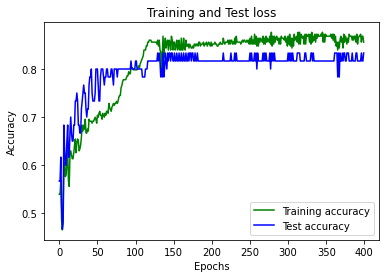

In [ ]:
learning_rate = 0.01

model = Net(len(data[0][0])).to(DEVICE)

optimizizer = optim.Adam(model.parameters(), lr = learning_rate)

loss_fn = nn.BCELoss()

training_loop(
n_epoch = 400,
optimizer = optimizizer,
model = model,
loss_fn = loss_fn,
train_loader = train_loader,
test_loader = test_loader,
print_plot = True
)